In [1]:
# Importing Required Libraries
import glob
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the first image and creating a dataframe of the same
file = "11114.png"
img = Image.open(file)
colourPixels = img.convert("RGB")
colourArray = np.array(colourPixels.getdata())
df1 = pd.DataFrame(colourArray, columns=["r","g","b"])
df1["final"] = [1 if ((df1.r.iloc[i]+df1.b.iloc[i]+df1.g.iloc[i])>350) else 0 for i in range(df1.shape[0])]
df1 = df1.drop(columns=['r','b','g'])
df2 = pd.DataFrame([int(file[0]),int(file[1]),int(file[2]),int(file[3]),int(file[4])], columns=["final"])
df1 = df1.append(df2)
df = pd.DataFrame(np.array(df1.T)).copy()

In [3]:
# Loading all of the remaining images
# Note that when loading images, all images are pushed to either 1 or 0, for white or black respectively
images=glob.glob("train_data/*.png")
for image in images:
    img = Image.open(image)
    colourPixels = img.convert("RGB")
    colourArray = np.array(colourPixels.getdata())
    df1 = pd.DataFrame(colourArray, columns=["r","g","b"])
    
    # Pusing the values to 1 or 0 respectively
    df1["final"] = [1 if ((df1.r.iloc[i]+df1.b.iloc[i]+df1.g.iloc[i])>350) else 0 for i in range(df1.shape[0])]
    
    df1 = df1.drop(columns=['r','b','g'])
    df2 = pd.DataFrame([int(image[11]),int(image[12]),int(image[13]),int(image[14]),int(image[15])], columns=["final"])
    df1 = df1.append(df2)
    df1 = pd.DataFrame(np.array(df1.T))
    df = df.append(df1)

In [4]:
# Resetting Index
df = df.reset_index().drop(columns=["index"])

In [5]:
# Renaming Columns
names = ["px"+str(i) for i in range(5460)]
names.append("no1")
names.append("no2")
names.append("no3")
names.append("no4")
names.append("no5")
df.columns = names

In [6]:
# The data. Rows represent images, while columns represent pixels. no1 to no5 are the digits
df.tail()

,px0,px1,px2,px3,px4,px5,px6,px7,px8,px9,...,px5455,px5456,px5457,px5458,px5459,no1,no2,no3,no4,no5
935,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,9,9,7,5,2
936,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,9,9,7,6,1
937,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,9,9,8,6,6
938,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,9,9,8,9,2
939,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,9,9,9,5,3


In [7]:
# Function which given an image of 130x42, outputs five smaller sub images of 7x10, each showing one digit
def extract_numbers(array):
    n = 42
    m = 130
    arr = np.resize(array[:m*n],(n,m))

    x1=[]    # Starting Pixels
    x2=[]    # Ending Pixels
    i = 0
    while(i<m):
        j=0
        while(j<n):
            if(arr[j,i]==0):            # When some text is found
                
                a = arr[j-1,i+1] if j>0 else 1
                b = arr[j,i+1]
                c = arr[j+1,i+1] if j<(n-1) else 1 
                d = arr[j+1,i] if j<(n-1) else 1
                
                if((a*b*c*d)==0):             # Checking that it is not just noise
                    
                    if(i>m-7):                # If it is at the end, ensuring we don't go beyond the boundary
                        x1.append(m-7)
                        i = i+7
                        x2.append(m)
                    else:
                        x1.append(i)
                        i = i+7
                        x2.append(i)
                break
            else:
                j=j+1
        i=i+1
    
    y1 = []    # Starting Pixels
    y2 = []    # Ending Pixels
    for k in range(len(x1)):
        a = x1[k]
        b = x2[k]
        j=0
        while(j<n):
            i=a
            while(i<b):                     # Searching only the zone of the above x
                if(arr[j,i]==0):            # When some text is found
                    
                    a = arr[j+1,i-1] if i>0 else 1
                    b = arr[j+1,i]
                    c = arr[j+1,i+1] if i<(m-1) else 1
                    d = arr[j,i+1] if i<(m-1) else 1
   
                    if((a*b*c*d)==0):             # Checking that it is not just noise

                        if(j>n-10):                # If it is at the end, ensuring we don't go beyond the boundary
                            y1.append(n-10)
                            j = j+10
                            y2.append(n)
                        else:
                            y1.append(j)
                            j = j+10
                            y2.append(j)
                    break
                else:
                    i=i+1
            j=j+1
    
    res = arr[y1[0]:y2[0],x1[0]:x2[0]].flatten()
    k=1
    while(k<len(x1)):
        a = arr[y1[k]:y2[k],x1[k]:x2[k]].flatten()        # Extracting the sub-images
        res = np.concatenate((res, a))
        k=k+1

    return(res)

In [8]:
# Extracting digit images of each image
char_df = pd.DataFrame(columns=[i for i in range(71)])

for i in range(df.shape[0]):
    array = df.iloc[i].to_numpy()
    chars = extract_numbers(array)
    chars = np.resize(chars, (5,70))

    # Appending the label also for each of the digit
    for k in range(5):
        arr = chars[k]
        arr = np.append(arr, array[42*130+k])
        df_temp = pd.DataFrame(arr)
        char_df = char_df.append(df_temp.T)
        
char_df = char_df.reset_index().drop(columns="index")

In [9]:
# A new dataset. Each image being 7x10 of one digit
names = ["pixel"+str(i) for i in range(70)]
names.append("label")
char_df.columns = names
char_df.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,label
4695,1,1,0,0,0,1,1,1,0,1,...,0,1,1,0,0,0,0,1,1,9
4696,1,1,0,0,0,1,1,1,0,1,...,0,1,1,0,0,0,0,1,1,9
4697,1,1,0,0,0,1,1,1,0,1,...,0,1,1,0,0,0,0,1,1,9
4698,0,0,0,0,0,0,0,0,1,1,...,0,1,1,0,0,0,0,1,1,5
4699,1,0,0,0,0,0,1,0,1,1,...,0,1,1,0,0,0,0,1,1,3


In [10]:
# Saving the data for further use
char_df.to_csv("train_data.csv",index=False)

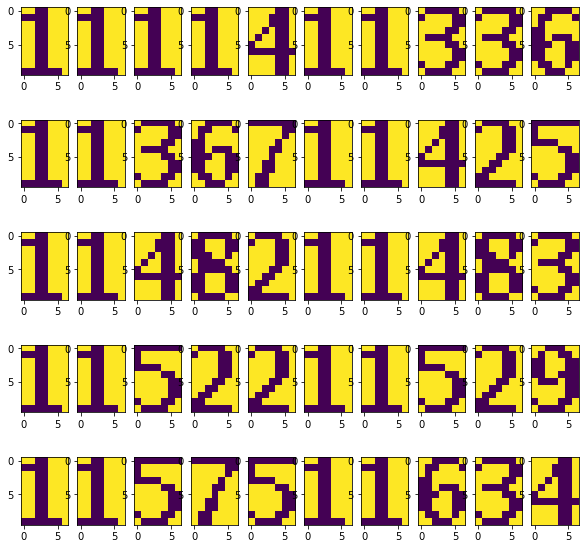

In [11]:
# Visualizing the first 50 digits
plt.figure(figsize=(10,10))
for i in range(50):
    arr = char_df.iloc[i].astype(int)[0:70]
    arr = np.resize(arr, (10,7))
    plt.subplot(5,10,i+1)
    plt.imshow(arr)